In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# fake beta function
def special_beta(alpha, beta): return special.gamma(alpha)*special.gamma(beta)/special.gamma(alpha+beta)

In [2]:
import eko.dglap as dglap
import eko.interpolation as interpolation
import eko.mellin as mellin

In [179]:
def get_Lagrange_basis_functions(xgrid_in, polynom_rank : int):
    # setup params
    xgrid = np.unique(xgrid_in)
    xgrid_size = len(xgrid)
    if not len(xgrid_in)  == xgrid_size:
        raise ValueError("xgrid is not unique")
    if xgrid_size < 2:
        raise ValueError("xgrid needs at least 2 points")
    if polynom_rank < 1:
        raise ValueError("need at least linear interpolation")
    if xgrid_size < polynom_rank:
        raise ValueError(f"to interpolate with rank {polynom_rank} we need at least that much points")

    # create blocks
    list_of_blocks = []
    for j in range(xgrid_size-1):
        kmin = max(0,j-polynom_rank//2)
        kmax = kmin + polynom_rank
        if kmax >= xgrid_size:
            kmax = xgrid_size - 1
            kmin = kmax - polynom_rank
        list_of_blocks.append((kmin,kmax))

    # setup basis functions
    list_of_basis_functions = [{"polynom_number": j, "areas": [{"lower_index": k, "reference_indices": None} for k in range(xgrid_size-1)]} for j in range(xgrid_size)]
    for j,current_block in enumerate(list_of_blocks):
        for k in range(current_block[0], current_block[1] + 1):
            list_of_basis_functions[k]["areas"][j]["reference_indices"] = current_block
    # compute
    def is_not_zero_sector(e):
        return not None == e["reference_indices"]
    for j,current_polynom in enumerate(list_of_basis_functions):
        # clean up zero sectors
        current_polynom["areas"] = list(filter(is_not_zero_sector,current_polynom["areas"]))
        # precompute coefficients
        xj = xgrid[j]
        for current_area in current_polynom["areas"]:
            denominator = 1.0
            coeffs = np.array([1])
            for k in range(current_area["reference_indices"][0],current_area["reference_indices"][1]+1):
                if k == j:
                    continue
                xk = xgrid[k]
                # Lagrange interpolation formula
                denominator *= (xj - xk)
                x_coeffs = np.insert(coeffs,0,0)
                Mxk_coeffs = -xk * coeffs
                Mxk_coeffs = np.append(Mxk_coeffs,np.zeros(len(x_coeffs)-len(Mxk_coeffs)))
                coeffs = x_coeffs + Mxk_coeffs
            # apply common denominator
            coeffs = coeffs / denominator
            current_area["coeffs"] = coeffs
            current_area["xmin"] = xgrid[current_area["lower_index"]]
            current_area["xmax"] = xgrid[current_area["lower_index"]+1]
            # clean up
            #del current_area["reference_indices"]
            #del current_area["lower_index"]
    # return
    return list_of_basis_functions

def evaluate_Lagrange_basis_function_x(x,conf):
    if not "areas" in conf or len(conf["areas"]) <= 0:
        raise ValueError("need some areas to explore")
    for current_area in conf["areas"]:
        if x <= current_area["xmin"] or x > current_area["xmax"]: # borders are (]
            continue
        polynom_rank = len(current_area["coeffs"])
        powers_in_x = np.array([x**k for k in range(polynom_rank)])
        return np.dot(current_area["coeffs"],powers_in_x)
    return 0.0

def evaluate_Lagrange_basis_function_N(N,conf):
    if not "areas" in conf or len(conf["areas"]) <= 0:
        raise ValueError("need some areas to explore")
    res = 0.0
    polynom_rank = len(conf["areas"][0]["coeffs"])
    for current_area in conf["areas"]:
        powers_x = []
        for j in range(polynom_rank):
            low = 0.0 if 0.0 == current_area["xmin"] else current_area["xmin"]**(N + j)
            up = current_area["xmax"]**(N + j)
            powers_x.append((up - low)/(N+j))
        res += np.dot(current_area["coeffs"],powers_x)
    return res

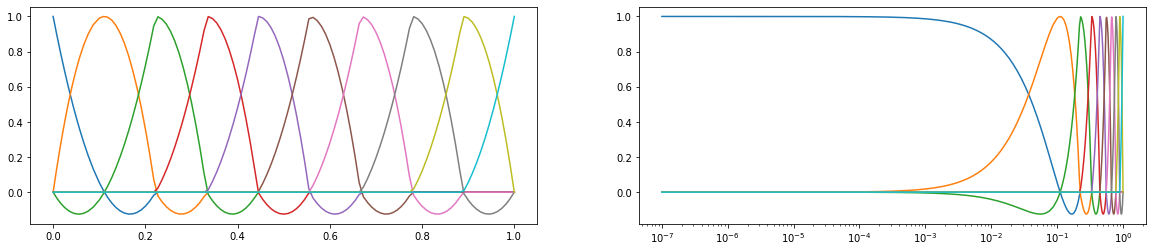

In [158]:
def plot_Lagrange_basis_functions(grid_size, polynom_rank,xmin=1e-7,title=None):
    cnfs = get_Lagrange_basis_functions(np.linspace(0,1,num=grid_size),polynom_rank)

    xs = np.append(np.logspace(np.log10(xmin),-1,num=100),np.linspace(0.1,1.,num=100))
    ys_list = [None] * grid_size
    for j,polynom_conf in enumerate(cnfs):
        ys_list[j] = [evaluate_Lagrange_basis_function_x(x,polynom_conf) for x in xs]

    fig = plt.figure(figsize=(20,4))
    if title is not None:
        plt.suptitle(title)
    plt.subplot(1,2,1)
    for ys in ys_list:
        plt.plot(xs,ys)
    plt.subplot(1,2,2)
    for ys in ys_list:
        plt.semilogx(xs,ys)
    return fig

plot_Lagrange_basis_functions(10,2);

In [141]:
def get_toy_pdf_x(alpha, beta):
    """test fnc in x"""
    return lambda x,alpha=alpha,beta=beta: x**alpha * (1-x)**beta
def get_toy_pdf_N(alpha, beta):
    return lambda N: special_beta(N+alpha,beta+1)

In [140]:
def plot_dist(x,y,yref,title=None):
    """compare to distributions both in linear and logarithmic x-space"""
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.05)
    if title is not None:
       fig.suptitle(title)
    # small x
    ax1 = plt.subplot(2,3,1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.title("small x")
    plt.loglog(x,y,"o")
    plt.loglog(x,yref,"x")
    plt.subplot(2,3,4,sharex=ax1)
    plt.loglog(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # linear x
    ax2 = plt.subplot(2,3,2)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.title("linear x")
    plt.plot(x,y,"o")
    plt.plot(x,yref,"x")
    plt.subplot(2,3,5,sharex=ax2)
    plt.semilogy(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # large x
    ax3 = plt.subplot(2,3,3)
    oMx = 1.0 - x
    plt.setp(ax3.get_xticklabels(), visible=False)
    oMx_min = 1e-2
    oMx_max = 0.5
    ax3.set_xlim(oMx_min,oMx_max)
    plt.title("large x, i.e. small (1-x)")
    plt.loglog(oMx,y,"o")
    plt.loglog(oMx,yref,"x")
    ax = plt.subplot(2,3,6,sharex=ax3)
    plt.loglog(oMx,np.abs((y - yref)/yref),"x")
    plt.xlabel("1-x")
    return fig

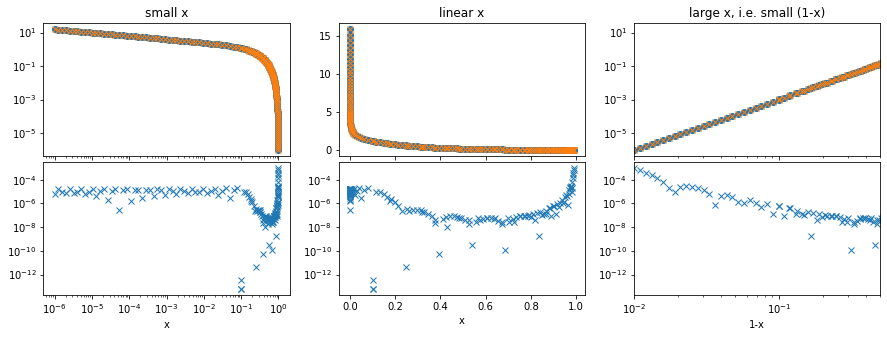

In [243]:
def test_interpolation_x(f,xgrid,polynom_rank,xmin=1e-6,title=None):
    """plots interpolation vs real thing in x"""
    confs = get_Lagrange_basis_functions(xgrid,polynom_rank)
    fs = [f(x) for x in xgrid]
    fp = lambda y,confs=confs,fs=fs: np.sum([fs[j]*evaluate_Lagrange_basis_function_x(y,confs[j]) for j in range(len(confs))])

    oMx = 1.0 - np.logspace(-2,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    yref = np.array([f(x) for x in xs])
    y = np.array([fp(x) for x in xs])

    return plot_dist(xs,y,yref,title=title)

toy_alpha = -0.2
toy_beta = 3.0
xgrid = np.unique(np.append(interpolation.get_xgrid_linear_at_log(80,1e-7,0.1),interpolation.get_xgrid_linear_at_id(50,0.1)))
polynom_rank = 4
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),xgrid,polynom_rank);

In [247]:
# test Mellin transformation
def test_mellin_correspondence(xgrid, polynom_rank):
    confs = get_Lagrange_basis_functions(xgrid, polynom_rank)
    for k,conf in enumerate(confs):
        for Nref in [1,2,3,np.complex(2,2),np.complex(2,-2)]:
            Nref = np.complex(Nref)
            e = evaluate_Lagrange_basis_function_N(Nref,conf)
            e = np.complex(e)
            i,ie = mellin.mellin_transform(lambda x,conf=conf: evaluate_Lagrange_basis_function_x(x,conf),Nref)
            err_type = "abs_err" if e == 0. else "rel_err"
            err = np.abs(i) if e == 0 else np.abs((e-i)/e)
            is_ok = "ok" if np.abs(e - i) < ie else "!!! don't match"
            print(f"polynom #{k:02d} at N={Nref}:\texact = {e: .3e},\tint = ({i: .3e})+-({ie:.2e}),\t|{err_type}| = {err:.3e} \t{is_ok}")

In [248]:
test_mellin_correspondence(np.linspace(0,1,num=10),3)

polynom #00 at N=(1+0j):	exact =  3.704e-02+0.000e+00j,	int = ( 3.704e-02+0.000e+00j)+-(3.89e-09+0.00e+00j),	|rel_err| = 1.403e-09 	ok
polynom #00 at N=(2+0j):	exact =  5.487e-04+0.000e+00j,	int = ( 5.487e-04+0.000e+00j)+-(8.63e-10+0.00e+00j),	|rel_err| = 2.104e-08 	ok
polynom #00 at N=(3+0j):	exact = -6.097e-05+0.000e+00j,	int = (-6.097e-05+0.000e+00j)+-(1.24e-08+0.00e+00j),	|rel_err| = 1.625e-08 	ok
polynom #00 at N=(2+2j):	exact =  1.314e-03-1.254e-04j,	int = ( 1.314e-03-1.254e-04j)+-(4.43e-09+1.31e-08j),	|rel_err| = 3.552e-07 	ok
polynom #00 at N=(2-2j):	exact =  1.314e-03+1.254e-04j,	int = ( 1.314e-03+1.254e-04j)+-(4.43e-09+1.31e-08j),	|rel_err| = 3.552e-07 	ok
polynom #01 at N=(1+0j):	exact =  1.435e-01+0.000e+00j,	int = ( 1.435e-01+0.000e+00j)+-(2.27e-11+0.00e+00j),	|rel_err| = 2.882e-14 	ok
polynom #01 at N=(2+0j):	exact =  1.355e-02+0.000e+00j,	int = ( 1.355e-02+0.000e+00j)+-(7.51e-10+0.00e+00j),	|rel_err| = 3.893e-11 	ok
polynom #01 at N=(3+0j):	exact =  1.478e-03+0.000e+00j,

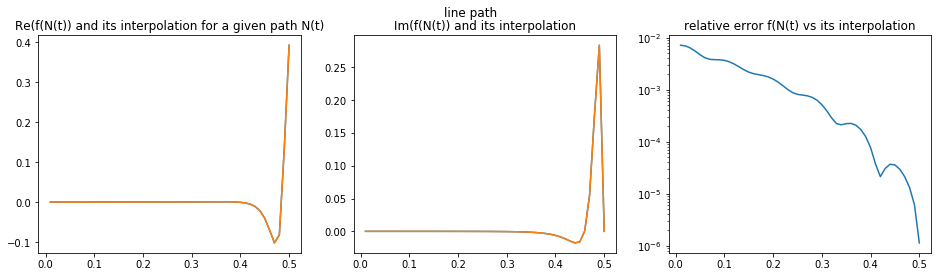

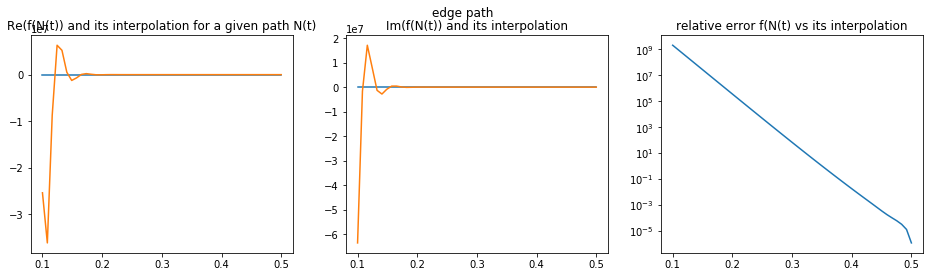

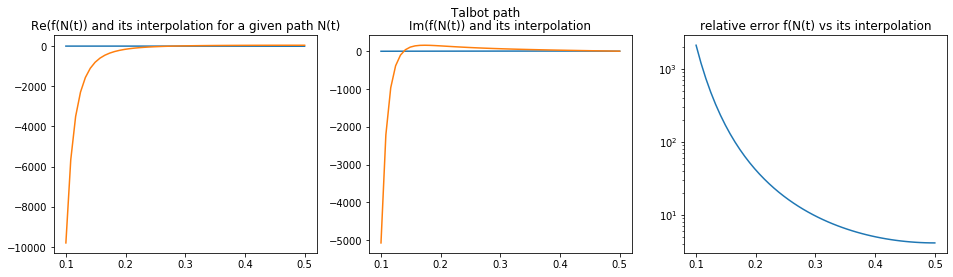

In [246]:
def test_interpolation_N(fx,fN,xgrid,polynom_rank,path,ts = np.linspace(0,1),title=None):
    """plots interpolation to real thing in x"""
    confs = get_Lagrange_basis_functions(xgrid,polynom_rank)
    fxs = [fx(x) for x in xgrid]
    fNp = lambda N,confs=confs,fxs=fxs: np.sum([fxs[j]*evaluate_Lagrange_basis_function_N(N,confs[j]) for j in range(len(confs))])

    fig = plt.figure(figsize=(16,4))
    if not title == None:
        plt.suptitle(title)
    plt.subplot(1,3,1)
    plt.title("Re(f(N(t)) and its interpolation for a given path N(t)")
    ys = [fN(path(t)) for t in ts]
    yps = [fNp(path(t)) for t in ts]
    plt.plot(ts,np.real(ys))
    plt.plot(ts,np.real(yps))
    plt.subplot(1,3,2)
    plt.title("Im(f(N(t)) and its interpolation")
    plt.plot(ts,np.imag(ys))
    plt.plot(ts,np.imag(yps))
    plt.subplot(1,3,3)
    plt.title("relative error f(N(t) vs its interpolation")
    plt.semilogy(ts,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(ts))])
    plt.show()
    return fig

toy_alpha = -0.2
toy_beta = 3.0
xgrid = np.unique(np.append(interpolation.get_xgrid_linear_at_log(80,1e-7,0.1),interpolation.get_xgrid_linear_at_id(50,0.1)))
polynom_rank = 4

path,jac = mellin.get_path_line(25)
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta), get_toy_pdf_N(toy_alpha,toy_beta),
                    xgrid,polynom_rank, path,np.linspace(.01,.5),title="line path");

path,jac = mellin.get_path_edge(10)
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta), get_toy_pdf_N(toy_alpha,toy_beta),
                    xgrid,polynom_rank, path,np.linspace(.1,.5),title="edge path");

path,jac = mellin.get_path_Talbot(.1)
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta), get_toy_pdf_N(toy_alpha,toy_beta),
                    xgrid,polynom_rank, path,np.linspace(.1,.5),title="Talbot path");

In [239]:
def test_inverse_Mellin_transform(fx,fN,path,jac,cut=0.,xmin=1e-6,title=None,num_total=100,oMx_min=1e-2):
    """plot Mellin integration path and compare numeric inversion to real thing"""
    oMx = 1.0 - np.logspace(np.log10(oMx_min),np.log10(.9),num=num_total//3)
    xs = np.append(np.logspace(np.log10(xmin),-1,num=num_total - 2*(num_total//3)),[np.linspace(0.1,.9,num=num_total//3),oMx])
    xs = np.sort(xs)
    ys = []
    yps = []
    for x in xs:
        yp,ype = mellin.inverse_mellin_transform(fN,path,jac,x,cut)
        yps.append(yp)
        y = fx(x)
        ys.append(y)
        rel_err = np.abs((yp - y)/y)
        print(f"x = {x:.3e}\ty = {y:.3e}\typ = {yp:.3e}+-{ype:.3e}\t|rel_err| = {rel_err:.3e}")

    return plot_dist(xs,np.array(yps),np.array(ys),title=title)

x = 1.000e-06	y = 1.585e+01	yp = 1.590e+01+-1.142e-01	|rel_err| = 3.192e-03
x = 4.642e-05	y = 7.355e+00	yp = 7.345e+00+-3.019e-07	|rel_err| = 1.381e-03
x = 2.154e-03	y = 3.393e+00	yp = 3.393e+00+-5.844e-11	|rel_err| = 2.031e-05
x = 1.000e-01	y = 1.155e+00	yp = 1.155e+00+-7.652e-10	|rel_err| = 3.130e-05
x = 1.000e-01	y = 1.155e+00	yp = 1.155e+00+-7.652e-10	|rel_err| = 3.130e-05
x = 1.000e-01	y = 1.155e+00	yp = 1.155e+00+-7.652e-10	|rel_err| = 3.130e-05
x = 5.000e-01	y = 1.436e-01	yp = 1.436e-01+-4.495e-09	|rel_err| = 9.288e-05
x = 9.000e-01	y = 1.021e-03	yp = 1.047e-03+-9.798e-09	|rel_err| = 2.561e-02
x = 9.051e-01	y = 8.710e-04	yp = 8.998e-04+-1.345e-08	|rel_err| = 3.310e-02
x = 9.900e-01	y = 1.002e-06	yp = -3.114e-05+-3.476e-09	|rel_err| = 3.208e+01


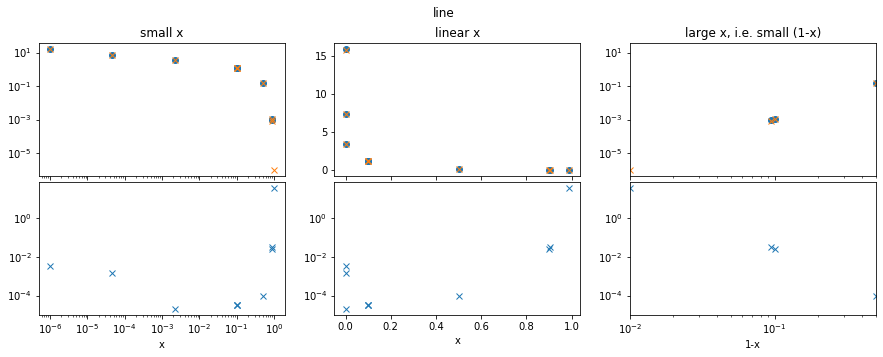

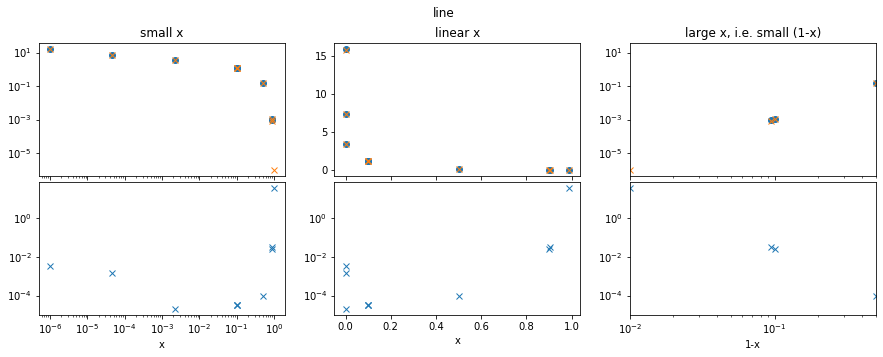

In [240]:
def test_inv_interpolation_x(fx,xgrid,polynom_rank,path,jac,cut=0.,title=None,num_total=100):
    """compare interpolated numeric inversion to real thing"""
    confs = get_Lagrange_basis_functions(xgrid,polynom_rank)
    fxs = [fx(x) for x in xgrid]
    fNp = lambda N,confs=confs,fxs=fxs: np.sum([fxs[j]*evaluate_Lagrange_basis_function_N(N,confs[j]) for j in range(len(confs))])

    return test_inverse_Mellin_transform(fx,fNp,path,jac,cut,title=title,num_total=num_total)


toy_alpha = -0.2
toy_beta = 3.0
xgrid = np.unique(np.append(interpolation.get_xgrid_linear_at_log(80,1e-7,0.1),interpolation.get_xgrid_linear_at_id(50,0.1)))
polynom_rank = 4
path,jac = mellin.get_path_line(25)
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),xgrid,polynom_rank,path,jac,title="line",num_total=10);